In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, GRU,Dropout, Bidirectional
from keras.callbacks import EarlyStopping,TensorBoard
import pickle
import joblib

## 1. Loading the dataset

In [23]:
df = pd.read_csv('yelp_training_set_review.csv')
df.head()

,stars,text_length,text_transformed
0,5,77,wife took birthday breakfast excellent weather...
1,5,111,idea people give bad reviews place goes show p...
2,5,44,Rosie Dakota LOVE Chaparral Dog Park convenien...
3,5,38,General Manager Scott Petello good egg go deta...
4,5,148,Drop drive ate go back next day food good cute...


## 2. EDA Analysis

In [24]:
df['stars'].unique()

array([5, 1])

In [25]:
# To make sure everything in text_transfromed columns is string data type. 
df['text_transformed'] = df['text_transformed'].astype('str', copy=True) 

In [26]:
# transform 5 star to 1 and 1 star to 0 for binary classification.
df['stars'] = df['stars'].apply(lambda x: 1 if x == 5 else 0)

In [27]:
df['stars'].value_counts()

stars
1    76193
0    17516
Name: count, dtype: int64

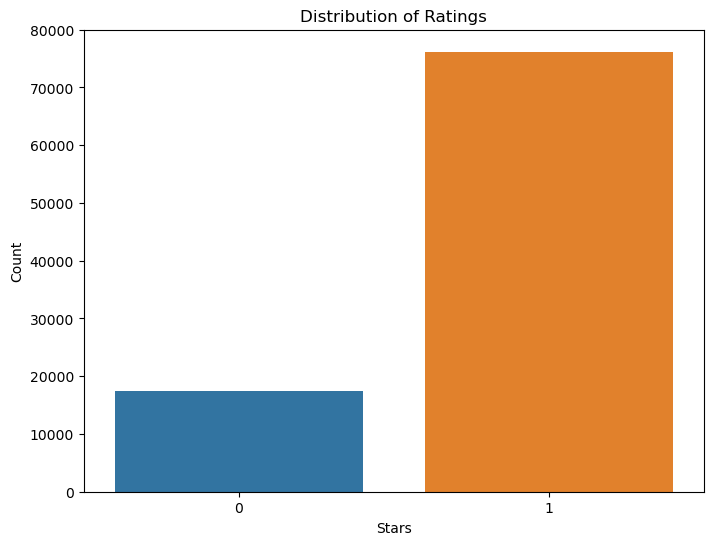

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='stars')
plt.title('Distribution of Ratings')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

**analysis** : The bar chart shows an imbalance in the distribution, with a higher frequency of positive reviews (1) compared to negative reviews (0). This imbalance could cause the model to become biased towards predicting the more frequent class. As a result, it may struggle to accurately predict the less frequent class. To overcome the class imbalance, I will use 'stratify=y' in the 'train_test_split' function. This ensures that the training and testing sets have the same class distribution, leading to more reliable model evaluation and better generalization to unseen data.

/Users/gulbakramxapkat/miniconda3/envs/metrica/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


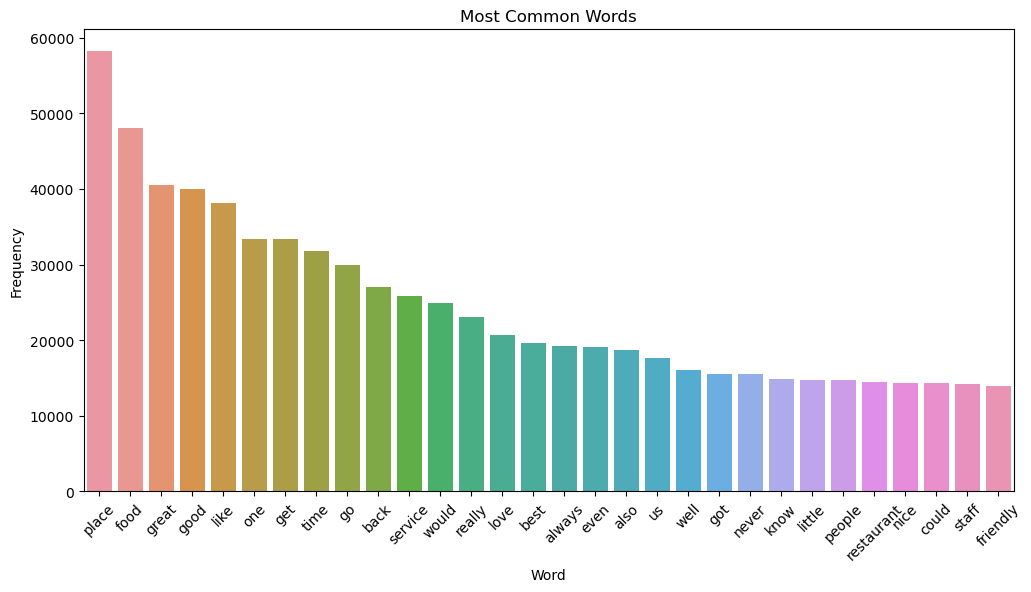

[('place', 58199),
 ('food', 48022),
 ('great', 40578),
 ('good', 40063),
 ('like', 38211),
 ('one', 33409),
 ('get', 33399),
 ('time', 31798),
 ('go', 29892),
 ('back', 27094),
 ('service', 25792),
 ('would', 24927),
 ('really', 23031),
 ('love', 20650),
 ('best', 19615),
 ('always', 19206),
 ('even', 19121),
 ('also', 18777),
 ('us', 17691),
 ('well', 16062),
 ('got', 15589),
 ('never', 15520),
 ('know', 14814),
 ('little', 14705),
 ('people', 14678),
 ('restaurant', 14535),
 ('nice', 14359),
 ('could', 14292),
 ('staff', 14187),
 ('friendly', 13895)]

In [29]:
# Tokenize the text and count word frequencies
all_words = ' '.join(df['text_transformed']).split()
word_freq = Counter(all_words)


# Plot the most common words
common_words = word_freq.most_common(30)
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
common_words

**Analysis** : The word 'place' appeared the most, followed by the word 'food', as it is a restaurant review. There are many words indicating positive sentiment like 'great', 'good', 'like', 'best', 'love', 'nice', and 'friendly', compared to words indicating negative sentiment like 'never'. This imbalance could lead to inflated accuracy on positive reviews but poorer performance on negative reviews. There are two main reasons why there are more positive words than negative words:

1. Imbalance in the distribution, as discussed in the previous bar chart.
2. Removal of stop word 'not': Stop words like "not" can completely change the meaning of a sentence. Removing them may lead to the loss of important contextual information, especially in cases where negation plays a crucial role in determining sentiment.

/Users/gulbakramxapkat/miniconda3/envs/metrica/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_length', ylabel='Count'>

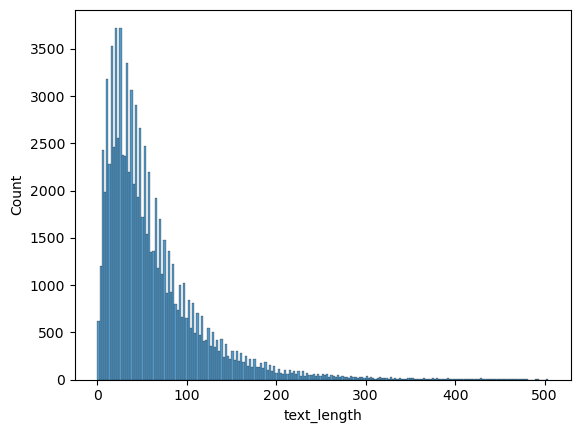

In [30]:
sns.histplot(df['text_length'])

**Analysis**: Text lengths vary significantly for each review. Defining the maximum text length for sentiment analysis helps optimize the analysis process. Therefore, to define the maximum text length that the model can handle efficiently, a histogram of the text lengths is plotted here. Since the majority of the lengths are distributed between 0 and 100, the text length is limited to 100 for model training.

In [31]:
# Define Maximum Text length
MAX_SEQUENCE_LENGTH = 100;

## 3. Tokenization and Pedding of the text Sequence

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_transformed'])
sequences = tokenizer.texts_to_sequences(df['text_transformed'])

In [33]:
COUNT_UNIQUE_WORDS = len(tokenizer.word_counts)
COUNT_UNIQUE_WORDS

74922

In [34]:
# To make sure that all input sequences in a dataset have the same length, which is crucial for efficient batch processing in neural networks.
pad_encoded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post') 

In [35]:
pad_encoded[:5],pad_encoded.shape

(array([[  276,   101,   476,   145,   112,  1109,   103,    45,   457,
           204,  4735,  2008,  1192,  1443,   327,   112,     2,   420,
           483,  2998,   303,   413,   396,   256,     5,     1,  4016,
            89,   483,  1477,     7,    57,  1553,     7,  2021,  1811,
          1170,   518,    15,    36,    89,    75,   231,   432,  1058,
          1929,    50,    40,    35,    56,    41,   449,   112,   351,
          2156,  3331,   564,  1679,  3489,   185,    42,    64,   710,
         15815,   152,    35,   242,    45,    92,   850,    15,   877,
            36,   607,    62,     9,    11,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  575,    25,    93,   100,   245,     1,   630,   448,   460,
           159,   211, 18692,    86,  1702,    78,    25,     5,   663,
           161,   420,  1248,   400,   444,    

## 4. Splitting Training Set and Testing Set

In [36]:
X = pad_encoded # features
y = df['stars'] # label

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=42, stratify=y)
#stratify is for dealing implance data

## 5. Building Models

### Defining Embedding Dimension to 5

In [38]:
EMBEDDING_DIM = 5;

### 5.1 Base Model: Embedding Model

In [39]:
# This will monitor the training loss and stop training if it hasn't improved for 10 consecutive epochs.
early_stop = EarlyStopping(monitor='loss', mode='min', patience=10)

In [22]:
model = Sequential()
model.add(Embedding(COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test,y_test), callbacks=[early_stop])

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### 5.1.1 Base Model Evaluation

In [43]:
def evaluate_and_plot_model(history):
    
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['accuracy'], label='train accuracy')

    plt.plot(history.history['val_loss'], label='validation loss')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()



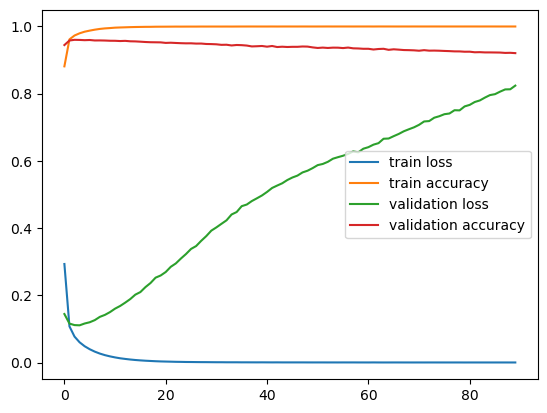

In [95]:
evaluate_and_plot_model(history)

**Model Analysis** The base model exhibits overfitting, as evidenced by the graph: while the training loss decreases, the evaluation loss increases. The training accuracy reaches around 100%, whereas the evaluation accuracy is around 90%. Overall, this indicates that the model is becoming too specialized to the training data and is beginning to perform worse on unseen data. Since Dropout layers help prevent overfitting by randomly setting a fraction of input units to 0 during training (This means that the dropout layer "drops out" some neurons during each training iteration, forcing the model to learn more robust features and reducing its reliance on any specific subset of neurons),Next, I am going to add a dropout layer to optimize the model performance.

### 5.2 Model2: Base Model Optimization by adding Dropout Layers

In [50]:
model2 = Sequential()
model2.add(Embedding(COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(Dropout(0.2))  # Add dropout with a rate of 0.2 before Flatten
model2.add(Flatten())
model2.add(Dropout(0.2))  # Add dropout with a rate of 0.2 after Flatten
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history_model2 = model2.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test,y_test), callbacks=[early_stop])

### 5.2.1 Model2 Evaluation

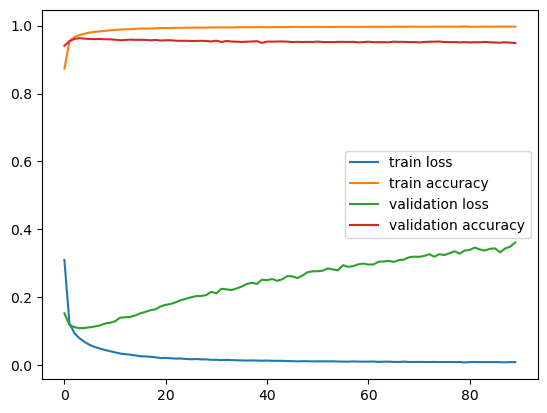

In [52]:
evaluate_and_plot_model(history_model2)

**Model Analysis**: Setting the dropout rate to 0.2 means that during training, 20% of the input units will be randomly set to 0 at each update, or in other words, 20% of the neurons will be "dropped out" during each training iteration. 
 By adding Dropout layers with a rate of 0.2, the model has shown improvement in performance. The validation loss of the optimized model decreased compared to the base model's validation loss, and the difference between training accuracy and validation accuracy decreased as well.
Next, to further optimize the model, I am going to increase the dropout rate to 0.3.

### 5.3 Model3: Model Optimization by increasing Dropout rate to 0.3

In [40]:
model3 = Sequential()
model3.add(Embedding(COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model3.add(Dropout(0.3))  # Add dropout with a rate of 0.3 before Flatten
model3.add(Flatten())
model3.add(Dropout(0.3))  # Add dropout with a rate of 0.3 after Flatten
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history_model3 = model3.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test,y_test), callbacks=[early_stop])

### 5.3.1 Model3 Evaluation

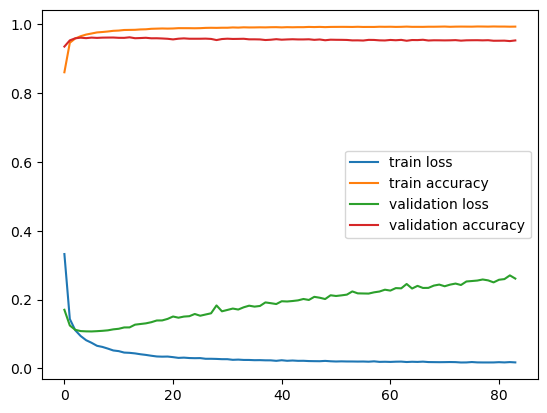

In [44]:
evaluate_and_plot_model(history_model3)

**Model Analysis**: By increasing the dropout rate to 0.3, the validation loss further decreased compared to other model. However, the validation accuracy did not show any increase compared to the previous model's validation accuracy.
Next, I am going to increase the dropout rate to 0.4 to see if it can improve the model.

### 5.4 Model4: Model Optimization by increasing Dropout rate to 0.4

In [45]:
model4 = Sequential()
model4.add(Embedding(COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model4.add(Dropout(0.4))  # Add dropout with a rate of 0.4 before Flatten
model4.add(Flatten())
model4.add(Dropout(0.4))  # Add dropout with a rate of 0.4 after Flatten
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history_model4 = model4.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test,y_test), callbacks=[early_stop])

### 5.4.1 Model4 Evaluation

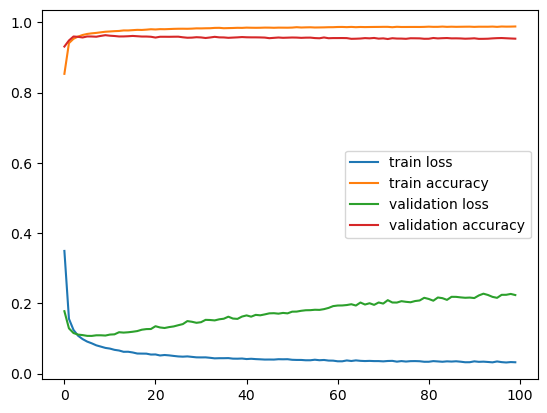

In [47]:
evaluate_and_plot_model(history_model4)

**Model Analysis**: By increasing the dropout rate to 0.4, the validation loss further decreased compared to the other models' evaluation loss. However, it did not show improved validation accuracy compared to the other models. Although the evaluation loss still increases, Model4 is the best among all the embedding models, as it performs better at minimizing the difference between the actual and predicted sentiment. Next, I am going to test Model4's performance on the testing data as shown below.

In [94]:
test = ['very nice food',
        'terrible',
        'I didn"t waited so long for this meal',
        'We waited for so long']

In [95]:
test_encoded = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [73]:
model4.predict(test_padded).round()

1/1 [==============================] - 0s 37ms/step


array([[1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

**Analysis**: Model4 correctly predicted the sentiment of 3 out of the 4 data points. It incorrectly predicted the positive sentiment as negative for the sentence 'I didn't waited so long for this meal.' This misclassification could be due to the word 'not' being removed along with other stop words, leading the model to make a negative prediction based on the words 'waited' and 'long.' Another possible reason is the imbalanced distribution of positive and negative ratings in the dataset. Imbalanced data can cause the model to perform exceptionally well on the more frequent class, as I discussed earlier during the EDA analysis.

### 5.4.2 Saving the Model

In [75]:
models = []
models.append(model4)

In [84]:
model_names = []
model_names.append('Embedding Model')

In [89]:
joblib.dump(model4,'model_files/embedding_model.joblib' )

['model_files/embedding_model.joblib']

In [90]:
joblib.dump(tokenizer, 'model_files/embedding_tokenizer.joblib')

['model_files/embedding_tokenizer.joblib']

### 5.5 Long Short Term Model(LSTM)

**Long Short Term Model(LSTM)**: LSTM is a type of recurrent neural network (RNN) architecture that is designed to remember information for long periods of time. It is particularly effective in capturing long-term dependencies in sequential data, making it well-suited for tasks such as language modeling, speech recognition, and sentiment analysis.

### 5.5.1 LSTM Base Model

In [143]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM.add(LSTM(1))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [144]:
history_LSTM= model_LSTM.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.5.2 LSTM Model Evaluation

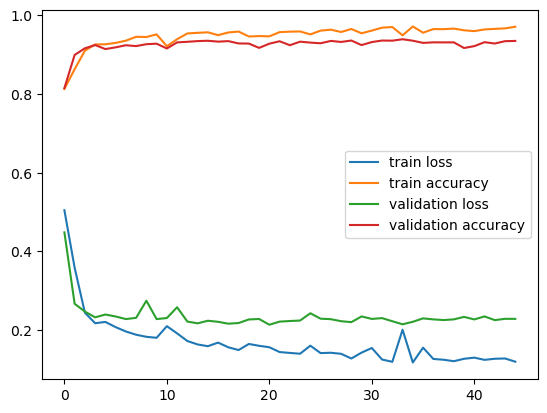

In [145]:
evaluate_and_plot_model(history_LSTM)

**Model Analysis**: The learning curve of the LSTM model showed fluctuations in accuracy and loss for both the training and testing sets, indicating a possible overfitting problem. To address this, I am going to add Dropout layers and a bidirectional LSTM as regularization techniques to the model next.


### 5.6 Model_LSTM_2: Model Optimization by adding dropout layers and bidirectional LSTM

In [185]:
model_LSTM_2 = Sequential()
model_LSTM_2.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM_2.add(Dropout(0.2))
model_LSTM_2.add(LSTM(1, return_sequences=True))
model_LSTM_2.add(Dropout(0.2))
model_LSTM_2.add(Dense(1, activation='sigmoid'))
model_LSTM_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [186]:
history_model_LSTM2 = model_LSTM_2.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.6.1 Model_LSTM_2 Evaluation

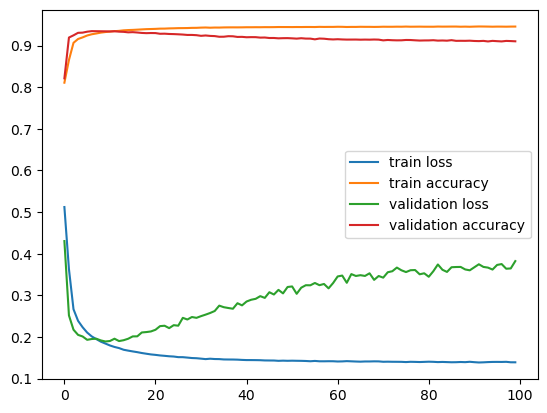

In [188]:
evaluate_and_plot_model(history_model_LSTM2)

**Model analysis**: Adding dropout layers and bidirectional LSTM layers to the LSTM base model significantly reduced the fluctuation problem in the learning curves. However, the evaluation loss increased while the training loss decreased, indicating an overfitting problem. To address this, I am going to increase the dropout rate from 0.2 to 0.3 next.

### 5.7 Model_LSTM_3: Model Optimization by Increasing Dropout rate to 0.3

In [54]:
model_LSTM_3 = Sequential()
model_LSTM_3.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM_3.add(Dropout(0.3))
model_LSTM_3.add(LSTM(1, return_sequences=True))
model_LSTM_3.add(Dropout(0.3))
model_LSTM_3.add(Dense(1, activation='sigmoid'))
model_LSTM_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
history_model_LSTM3 = model_LSTM_3.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.7.1 Model_LSTM_3 Evaluation

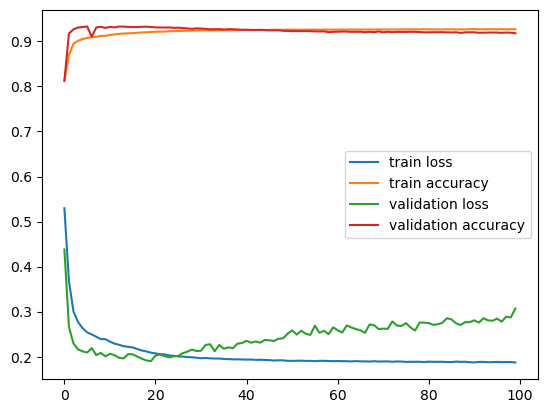

In [47]:
evaluate_and_plot_model(history_model_LSTM3)

**Model Analysis**: After increasing the dropout rate to 0.3, the evaluation loss decreased significantly compared to that of previous models. Although there is still fluctuation and increase in the evaluation curve, model_LSTM_3 is by far the best LSTM model. Next, I am going to test its performance using the testing data.

test = ['very nice food',

        'terrible',
        
        'I didn"t waited so long for this meal',
        
        'We waited for so long']

In [104]:
model_LSTM_3.predict(test_padded).round()[:4,:1]

1/1 [==============================] - 0s 9ms/step


array([[[1.]],

       [[0.]],

       [[1.]],

       [[1.]]], dtype=float32)

**Analysis**

LSTM_3 Model has correctly predicted the sentiment of 3 out of 4 data points. Unlike the embedding model, it correctly predicted the negative sentiment of the sentence 'I didn't wait so long for this meal'. However, it misclassified the sentiment of 'We waited for so long' as positive. The possible reason could be LSTM model may have learned different representations for similar phrases like 'waited' and 'long'compared to embedding model.

### 5.7.2 Saving the Model

In [76]:
models.append(model_LSTM_3)

In [85]:
model_names.append('LSTM Model')

In [91]:
joblib.dump(model_LSTM_3,'model_files/LSTM_model.joblib' )

['model_files/LSTM_model.joblib']

### 5.8 Gated Recurrent Unit Model (GRU)

**Gated Recurrent Unit Model (GRU)**: A Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture that is similar to the Long Short-Term Memory (LSTM) architecture but has a simpler design. GRUs were designed to be more computationally efficient while maintaining comparable performance to LSTMs.

### 5.8.1 GRU Model Base Model

In [170]:
model_GRU= Sequential()
model_GRU.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_GRU.add(GRU(1))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [171]:
history_model_GRU = model_GRU.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.8.2 GRU Base Model Evaluation

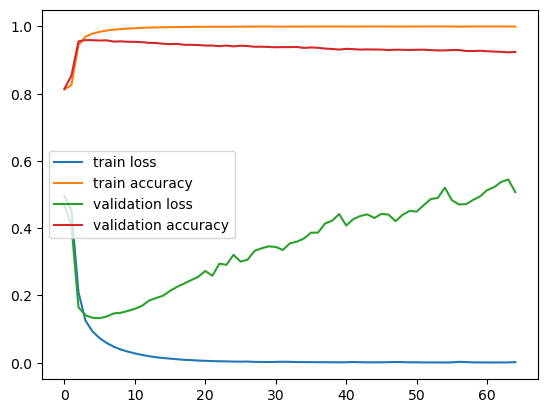

In [173]:
evaluate_and_plot_model(history_model_GRU)

**Model Analysis**: 

The learning curve of the GRU base model indicates an overfitting problem, as the evaluation loss is increasing while the training loss is decreasing, and the evaluation accuracy is not as high as the training accuracy. To tackle this, I am going to add Dropout layers and a bidirectional GRU layer to the GRU base model.

### 5.9 Model_GRU_2: Model Optimization by adding dropout layers, and a bidirectional GRU layer

In [34]:
model_GRU_2 = Sequential()
model_GRU_2.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_GRU_2.add(Dropout(0.2))
model_GRU_2.add(GRU(1, return_sequences=True)) # adding a bidirectional GRU layer¶
model_GRU_2.add(Dropout(0.2))
model_GRU_2.add(Dense(1, activation='sigmoid'))


In [35]:
model_GRU_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history_model_GRU2 = model_GRU_2.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.9.1 model_GRU_2 Evaluation

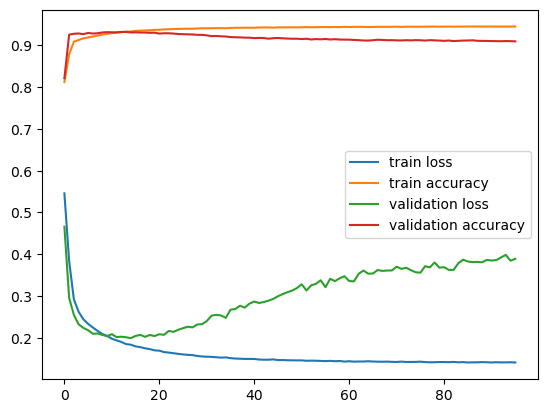

In [37]:
evaluate_and_plot_model(history_model_GRU2)

**Model Analysis**:

Adding Dropout layers and bidirectional GRU layers significantly improved model performance by increasing the evaluation accuracy and slowing down the increase in evaluation loss. To further optimize the model, I am going to increase the dropout rate to 0.3 next.

### 5.10.1 Model_GRU_3: Model Optimization by increasing dropout layers to 0.3

In [39]:
model_GRU_3 = Sequential()
model_GRU_3.add(Embedding(input_dim=COUNT_UNIQUE_WORDS+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_GRU_3.add(Dropout(0.3))
model_GRU_3.add(GRU(1, return_sequences=True)) # adding a bidirectional GRU layer¶
model_GRU_3.add(Dropout(0.3))
model_GRU_3.add(Dense(1, activation='sigmoid'))
model_GRU_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_GRU3 = model_GRU_3.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(X_test, y_test),callbacks=[early_stop])

### 5.10.2 Model_GRU_3 Evaluation

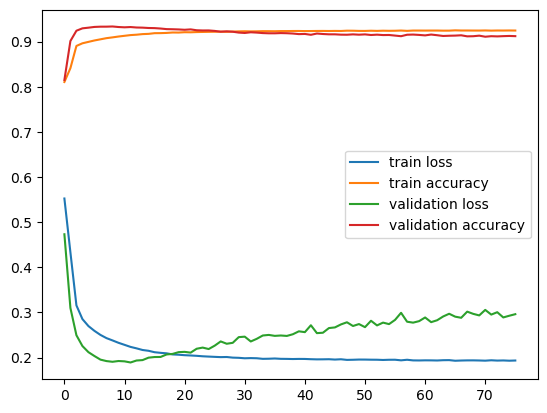

In [40]:
evaluate_and_plot_model(history_model_GRU3)

**Model Analysis**

Increasing the dropout rate to 0.3 further improved the model performance. However, there is still an overfitting problem, as the evaluation curve is fluctuating and still increasing. Model_GRU_3 is by far the best model among the other GRU models.

### 5.10.3 Model_GRU_3 Testing

In [103]:
model_GRU_3.predict(test_padded).round()[:4,:1]

1/1 [==============================] - 0s 9ms/step


array([[[1.]],

       [[0.]],

       [[1.]],

       [[1.]]], dtype=float32)

**Analysis**:

Just like the LSTM model, model_GRU_3 has correctly predicted the sentiment of 3 out of 4 data points. Unlike embedding model, it correctly predicted the negative sentiment of the sentence 'I didn't wait so long for this meal' but misclassified the sentiment of 'We waited for so long' as positive. One possible reason for this difference could be that both the GRU and LSTM models learned different representations for similar phrases like 'waited' and 'long' compared to the embedding model.


In [77]:
models.append(model_GRU_3)

In [86]:
model_names.append('GRU Model')

In [92]:
joblib.dump(model_GRU_3,'model_files/GRU_model.joblib' )

['model_files/GRU_model.joblib']

### Models Comparision 

In [87]:
def plot_test_metrics(models, model_names, X_test, y_test):
    test_losses = []
    test_accuracies = []

    for model in models:
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, test_losses, width, label='Test Loss')
    rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

    ax.set_ylabel('Metrics')
    ax.set_title('Test Metrics for Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()



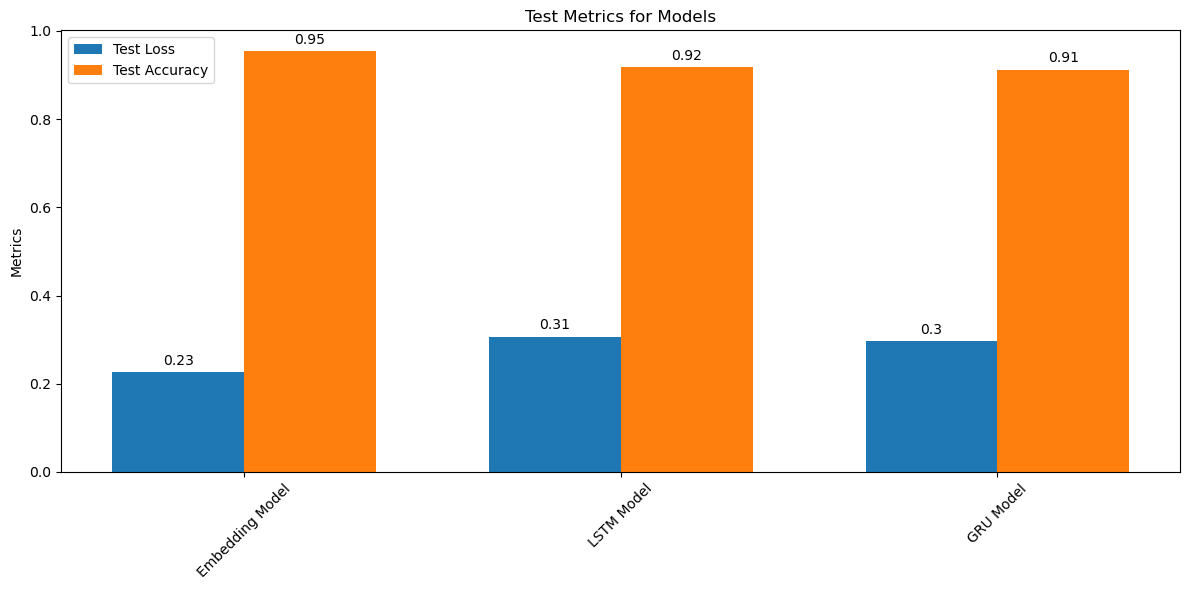

In [88]:
plot_test_metrics(models,model_names, X_test, y_test)

**Analysis**: 

The Embedding model achieved a higher test accuracy of 95% and a relatively lower test loss of 0.23 compared to the LSTM and GRU models. This indicates that the Embedding model is better at minimizing the difference between the actual and predicted sentiment values, suggesting lower overfitting compared to the other models. Additionally, the Embedding model is better at predicting the sentiment of the comments than the LSTM and GRU models.

**Conclusion**

Based on the above analysis, Model4, the embedding model with dropout layers stands out as the best among all the models I developed, exhibiting fewer overfitting problems. To further optimize the model, I will explore additional methods to reduce overfitting, such as undersampling the majority class, using class weights during training and Hyperparameter Tuning.